# Feature engineering notebook

In this notebook the feature engineering part of the data preprocessing takes place. In the data exploration notebook we have found some interesting features about the data, checked the distributions and found outlier datapoints which possibly would disturb the learning. In this notebook we carry out some preprocessing to remedy the issues found with the dataset, construct the features vector - label pairs and to split the dataset into train, validation and test sets.

## Structure

The following preprocessing steps are going to be carried out:
* converting the lengths of the offers into hours
* extracting features from the transcript datasets value column
* Removing the people and all of their transactions from the data who are considered to be outliers based on their total spent money during the 30 day period
* Encode the gender in the profile dataset by one-hot-encoding: 'M', 'F', 'O', 'U'
* Standardizing the non missing values in the age and income data with sklearn's StandardScaler.
* Filling up the None type values in the age and income columns with zeros (mean after standardization)
* calculate the membership length and remove the became_member_on field.
* Transforming the membership length dataset with sklearn's QuantileTransformer
* Creating the training dataset by creating feature vectors for every received offer and creating label for it which puts the offer in one of the following cathegories:
    0. not viewed, not completed
    1. not viewed but completed
    2. viewed but not completed
    3. viewed and completed
* splitting the dataset into training, validation and test datasets
* creating the data loaders
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler, quantile_transform
from importlib import reload
from source import feature_helpers, exploration_helpers, training_data


In [2]:
reload(feature_helpers)
reload(training_data)
from source.training_data import get_training_data

### loading the data

In [3]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Converting the lengths of offers into hours

In [4]:
# converting the duration into hours:
portfolio.duration = portfolio.duration.apply(lambda x: x * 24)

### Extracting transcript values

In [5]:
# extracting the transaction values:
transcript = exploration_helpers.extract_transcript_values(transcript)

### Removing outliers

Removing persons from the dataset who have outlier amount of spent money. First the total amount of money spent per person is calculated:

In [6]:
cache_dir = 'cache'
cache_file = 'profile_total_spent.csv'
profile = feature_helpers.get_total_spent(profile, transcript, cache_file=os.path.join(cache_dir, cache_file))

Read preprocessed data from cache file: cache/profile_total_spent.csv


In [7]:
profile.head()

,gender,age,id,became_member_on,income,total_spent
0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,20.40
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,77.01
2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,14.30
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,159.27
4,NaN,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,4.65


The the outliers are removed:

In [8]:
print('Number of people originally: {}'.format(len(profile.index)))
print('Number of transcript data originally: {}'.format(len(transcript.index)))

# removing outplier spending people.
profile, transcript = feature_helpers.remove_outliers(profile, transcript, lower_threshold=0, upper_threshold=300)

print('Number of people without outliers: {}'.format(len(profile.index)))
print('Number of transcript data without outliers: {}'.format(len(transcript.index)))

Number of people originally: 17000
Number of transcript data originally: 306534
Number of people without outliers: 15840
Number of transcript data without outliers: 284047


It can be seen that around 6.8% of the people and around 7.3% of the total transcript data is removed.

### One-hot-encoding the gender

For further use the gender has to be encoded using one-hot-encoding.

In [9]:
# encoding gender:
profile = feature_helpers.encode_gender(profile)

profile[1: 10]

,F,M,O,U,age,id,became_member_on,income,total_spent
1,1,0,0,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,77.01
2,0,0,0,1,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,14.30
3,1,0,0,0,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,159.27
4,0,0,0,1,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,4.65
5,0,1,0,0,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,57.73
7,0,0,0,1,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN,0.24
8,0,1,0,0,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,36.43
9,0,0,0,1,118,8974fc5686fe429db53ddde067b88302,20161122,NaN,15.62
10,0,0,0,1,118,c4863c7985cf408faee930f111475da3,20170824,NaN,66.41


### Standardizing age and income

standardizing the age and income data using sklearn's StandarScaler.

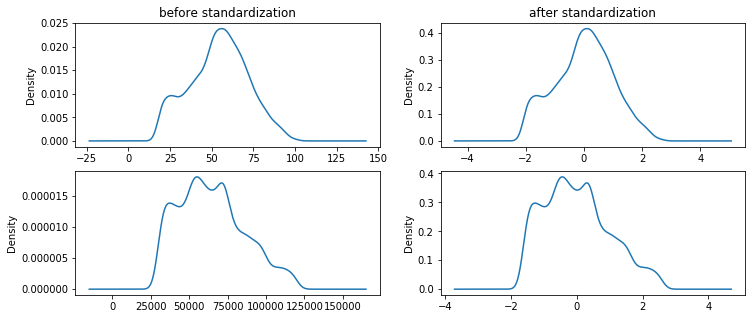

In [10]:
fig, axis = plt.subplots(figsize=(12,5), nrows=2, ncols=2)
# instantiating the standard scaler object:
standard_scaler = StandardScaler()

# transforming the data:
profile.loc[(profile.age == 118), 'age'] = None  # standard scaler scips none type values

profile.age.plot.density(ax=axis[0][0])
profile.income.plot.density(ax=axis[1][0])
axis[0][0].set_title('before standardization')

profile.loc[:, 'age'] = standard_scaler.fit_transform(profile.age.values.reshape(-1, 1))
profile.loc[:, 'income'] = standard_scaler.fit_transform(profile.income.values.reshape(-1, 1))

profile.age.plot.density(ax=axis[0][1])
profile.income.plot.density(ax=axis[1][1])
axis[0][1].set_title('after standardization')

plt.show()

### Filling up None type values

The age and income data of the people who belong to the Unknown cathegory will be filled with the respective means.

In [11]:
# filling up the unknown values in the age column:
profile.loc[profile.age.isna(), 'age'] = 0
profile.loc[profile.income.isna(), 'income'] = 0

profile.head()

,F,M,O,U,age,id,became_member_on,income,total_spent
0,0,0,0,1,0.000000,68be06ca386d4c31939f3a4f0e3dd783,20170212,0.000000,20.40
1,1,0,0,0,0.048437,0610b486422d4921ae7d2bf64640c50b,20170715,2.214943,77.01
2,0,0,0,1,0.000000,38fe809add3b4fcf9315a9694bb96ff5,20180712,0.000000,14.30
3,1,0,0,0,1.193501,78afa995795e4d85b5d9ceeca43f5fef,20170509,1.654475,159.27
4,0,0,0,1,0.000000,a03223e636434f42ac4c3df47e8bac43,20170804,0.000000,4.65


### Calculating membership length

Calculating the membership length and removing the became_member_on field.

In [12]:
profile = exploration_helpers.get_membership_length(profile)

profile.head()

,F,M,O,U,age,id,income,total_spent,membership_length
0,0,0,0,1,0.000000,68be06ca386d4c31939f3a4f0e3dd783,0.000000,20.40,529
1,1,0,0,0,0.048437,0610b486422d4921ae7d2bf64640c50b,2.214943,77.01,376
2,0,0,0,1,0.000000,38fe809add3b4fcf9315a9694bb96ff5,0.000000,14.30,14
3,1,0,0,0,1.193501,78afa995795e4d85b5d9ceeca43f5fef,1.654475,159.27,443
4,0,0,0,1,0.000000,a03223e636434f42ac4c3df47e8bac43,0.000000,4.65,356


### Transforming the membership length

As the membership length distribution is strongly left skewed, it has to be transformed to an approximate normal distribution using sklearn's quantile_transform method.

Text(0.5, 1.0, 'After transformation')

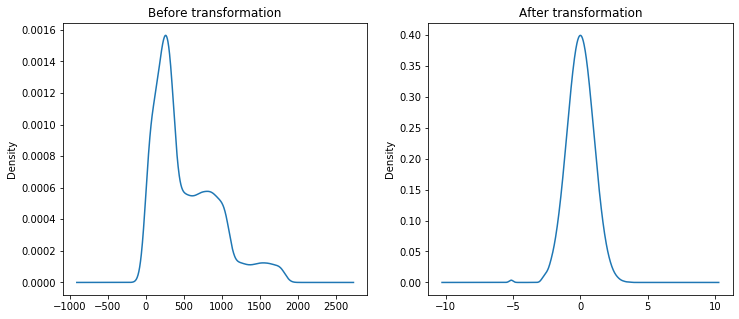

In [13]:
# plotting the membership length before and after the transformation:
fig, axis = plt.subplots(figsize=(12,5), nrows=1, ncols=2)

profile.membership_length.plot.density(ax=axis[0])
axis[0].set_title('Before transformation')

# transforming the membership length to norma distribution
profile.loc[:, 'membership_length'] = quantile_transform(profile.membership_length.values.reshape(-1, 1),
                                                        n_quantiles=1000,
                                                        output_distribution='normal',
                                                        copy=True)
# standardizing the gotten normal distribution:
profile.loc[:, 'membership_length'] = standard_scaler.fit_transform(profile.membership_length.values.reshape(-1, 1))

profile.membership_length.plot.density(ax=axis[1])
axis[1].set_title('After transformation')

### Creating the training data

The training data is composed of feature vector - label pairs. Both feature vectors and correspoding labels are manufactured in the followings. These are stored in a DataFrame called training_data. The training_data is also saved into a .csv file, so that it does not have to be re-manufactured every time.

There are going to be a training point (feature vector - label pair) for every received offer. The feature vector is going to be composed of the following fields:
* gender
* age
* income
* membership length
* average spent money a day until receiving the offer
* number of received offers until receiving the offer
* ratio of viewed / received offers until receiving the offer
* ratio of completed / viewed offers until receiving the offer
* ratio of completed not viewed / received offers until receiving the offer
* number of received offers of this type until receiving the offer
* ratio of viewed / received offers of this type until receiving the offer
* ratio of completed / viewed offers of this type until receiving the offer
* ratio of completed not viewed / received offers of this type until receiving the offer
* one-hot-encoding of the currently received offer type

The label is going to be the number of one of the following categories regarding the currently received offer:
0. not viewed, not completed
1. not viewed but completed
2. viewed but not completed
3. viewed and completed

### Test transcript

We have created a test_transcript.json file, which contains some transcript data. It contains all the possible situations that can occure during training data generation. It contains only one person for the sake of simplicity. We have checked whether the get_training_data() function works correctly.

In [14]:
# loading test transcript:
test_transcript = pd.read_json('data/test_transcript.json', orient='records', lines=True)
test_transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 0.8300000000000001},0
1,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0
3,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},1
4,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},2
5,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},4
6,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},5
7,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},6
8,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},7
9,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 4.3},8


In [17]:
# extracting the transaction values:
test_transcript = exploration_helpers.extract_transcript_values(test_transcript)

test_training_data = get_training_data(profile, test_transcript, portfolio,
                                       target_dir='data', target_file='test_training_data.csv', 
                                       cache_dir='cache', pruning_cache=None,
                                       pruning_cache_file_to_write='pruned_received_offers_test.csv')


print(test_training_data.iloc[:, 0:7])
print(test_training_data.iloc[:, 7:15])
print(test_training_data.iloc[:, 15:])

pruning received offers.
No cache file was given
cache was saved to cache/pruned_received_offers_test.csv
pruning is complete.
number of training points: 8
training dataset was saved to data/test_training_data.csv
   F  M  O  U     age   income membership_length
0  1  0  0  0  1.1935  1.65447          0.132255
1  1  0  0  0  1.1935  1.65447          0.132255
2  1  0  0  0  1.1935  1.65447          0.132255
3  1  0  0  0  1.1935  1.65447          0.132255
4  1  0  0  0  1.1935  1.65447          0.132255
5  1  0  0  0  1.1935  1.65447          0.132255
6  1  0  0  0  1.1935  1.65447          0.132255
7  1  0  0  0  1.1935  1.65447          0.132255
  av_money_spent num_received viewed/received completed/viewed  \
0              0            0               0                0   
1              0            0               0                0   
2          19.92            2               0                0   
3           4.98            3        0.333333                0   
4           3.3

### Training data generation

After we made sure that the training data generation works just fine, we run the function on the real transcript data and created the real training_data.csv file.

In [16]:
training_data_df = get_training_data(profile, transcript, portfolio,
                                  target_dir='data', target_file='training_data.csv',
                                  cache_dir='cache', pruning_cache='pruned_received_offers.csv')


pruning received offers.
Read pruned data from cache file:  cache/pruned_received_offers.csv
pruning is complete.
number of training points: 61324
1000 out of 61324 training points are complete.
2000 out of 61324 training points are complete.
3000 out of 61324 training points are complete.
4000 out of 61324 training points are complete.
5000 out of 61324 training points are complete.
6000 out of 61324 training points are complete.
7000 out of 61324 training points are complete.
8000 out of 61324 training points are complete.
9000 out of 61324 training points are complete.
10000 out of 61324 training points are complete.
11000 out of 61324 training points are complete.
12000 out of 61324 training points are complete.
13000 out of 61324 training points are complete.
14000 out of 61324 training points are complete.
15000 out of 61324 training points are complete.
16000 out of 61324 training points are complete.
17000 out of 61324 training points are complete.
18000 out of 61324 training p

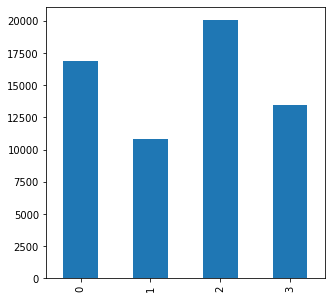

In [17]:
# checking how many data are there for each label:
label_counts_df = training_data_df.label.value_counts().sort_index()
fig = plt.figure(figsize=(5,5))
label_counts_df.plot.bar()

The number of training samples in the classes is quite different, so it will have to be considered during cross entropy loss calculation. (Weighing factor)

### Standardizing the generated data:

In [18]:
training_data_df.columns

Index(['F', 'M', 'O', 'U', 'age', 'income', 'membership_length',
       'av_money_spent', 'num_received', 'viewed/received', 'completed/viewed',
       'completed_not_viewed', 'num_received_this', 'viewed/received_this',
       'completed/viewed_this', 'completed_not_viewed_this', 'offer_0',
       'offer_1', 'offer_2', 'offer_3', 'offer_4', 'offer_5', 'offer_6',
       'offer_7', 'offer_8', 'offer_9', 'informational', 'bogo', 'discount',
       'label'],
      dtype='object')

In [19]:
columns = ['av_money_spent', 'num_received', 'viewed/received', 'completed/viewed',
           'completed_not_viewed', 'num_received_this', 'viewed/received_this',
           'completed/viewed_this', 'completed_not_viewed_this']

training_data_df.loc[:, columns] = standard_scaler.fit_transform(training_data_df.loc[:, columns].values)

Saving again the standardized training data

In [20]:
target_dir = 'data'
target_file = 'training_data_standardized.csv'
with open(os.path.join(target_dir, target_file), 'w'):
    training_data_df.to_csv(os.path.join(target_dir, target_file))
    print('training dataset was saved to {}'.format(os.path.join(target_dir, target_file)))

training dataset was saved to data/training_data_standardized.csv
